In [1]:
import os
import pickle
import re
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
import umap
from kneed import KneeLocator
from matplotlib.lines import Line2D
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from sklearn.cluster import (AgglomerativeClustering, Birch, KMeans,
                             SpectralClustering)
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score,
                             silhouette_score)
from tqdm import tqdm

In [2]:
sns.set_style("whitegrid")
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
def load_anthems_data(path="./data/data.pickle", 
                      punctuation_to_keep=",.;?!'-", 
                      lyrics_lowercase=False, 
                      countries_lowercase=False, 
                      clean_countries=False, # remove additional text in parantheses (e.g years) 
                      keep_countries_without_lyrics=True,
                      keep_countries_with_invalid_iso2=False,
                      add_iso3_codes=True):
                        
    with open(path, "rb") as handle:
        data = pickle.load(handle)

    _df = pd.DataFrame.from_dict(data, orient="index", columns=["iso_2", "lyrics"])
    countries_iso_2 = [country.alpha_2 for country in list(pycountry.countries)]
    countries_iso_3 = [country.alpha_3 for country in list(pycountry.countries)]

    if not keep_countries_with_invalid_iso2:
        df = _df.loc[_df["iso_2"].isin(countries_iso_2)].copy()  # Create a copy of the DataFrame slice
    else: df = _df.copy()

    if add_iso3_codes:
        if keep_countries_with_invalid_iso2:
            raise ValueError("Cannot add iso3 codes when `keep_countries_with_invalid_iso2` is set to `True`")
        df["iso_a3"] = np.array(countries_iso_3)[[countries_iso_2.index(i) for i in df["iso_2"].values]]
        df.loc["Kosovo", :] = _df.loc["Kosovo"].to_list() + ["-99"]
        df.loc["Somaliland", :] = _df.loc["Somaliland"].to_list() + ["SOL"]
        columns = ["iso_2", "iso_a3", "lyrics"]
    else: columns = ["iso_2", "lyrics"]

    punctuation_pattern = "[^\\w\\d" + "\\".join(list(punctuation_to_keep)) + "\\s]+" 
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r"[0-9][\.]?", "", text)) # remove numbers and numbers with dot
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r"chorus", "", text, flags=re.IGNORECASE)) # remove CHORUS strings
    df["lyrics"] = df["lyrics"].apply(lambda text: text.replace("\r", " ").replace("\n", " ")) # remove newline characters
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r" {2,}", " ", text)) # remove double spaces
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(punctuation_pattern, "", text)) # remove selected punctuation
    df["lyrics"] = df["lyrics"].apply(lambda text: text.strip()) # remove trailing spaces
    if lyrics_lowercase:
        df["lyrics"] = df["lyrics"].apply(lambda text: text.lower())
    if countries_lowercase:
        df.index = df.index.str.lower()
    if clean_countries: # remove additional text in parantheses (e.g years)
        df.index = df.index.map(lambda name: re.sub(r"(\(.*\))|(\[.*\])", '', name).strip())
    if not keep_countries_without_lyrics:
        df = df[df["lyrics"] != ""]

    return df[columns].sort_index(inplace=False)

In [4]:
df = load_anthems_data()

In [5]:
df

,iso_2,iso_a3,lyrics
504 Gateway Time-out,BH,BHR,
Afghanistan (2006- (in exile since 2021)),AF,AFG,This land is Afghanistan It is pride of every ...
Aland Islands,AX,ALA,"The land of thousand islands and skerries, Bor..."
Albania,AL,ALB,"Around our flag we are united, With one will a..."
Algeria,DZ,DZA,"We swear by the lightning that destroys, By th..."
...,...,...,...
Wallis and Futuna,WF,WLF,
Western Sahara,EH,ESH,"O sons of the Sahara! In the battlefield, you ..."
Yemen,YE,YEM,"Repeat, Oh World, my song. Echo it over and ov..."
Zambia,ZM,ZMB,"Stand and sing of Zambia, proud and free, Land..."


In [6]:
clean_df = df[df.lyrics != ""]

In [7]:
clean_df

,iso_2,iso_a3,lyrics
Afghanistan (2006- (in exile since 2021)),AF,AFG,This land is Afghanistan It is pride of every ...
Aland Islands,AX,ALA,"The land of thousand islands and skerries, Bor..."
Albania,AL,ALB,"Around our flag we are united, With one will a..."
Algeria,DZ,DZA,"We swear by the lightning that destroys, By th..."
American Samoa,AS,ASM,Amerika Samoa My most beloved country I hail f...
...,...,...,...
Vietnam,VN,VNM,"Soldiers of Vietnam, we go forward, With the o..."
Western Sahara,EH,ESH,"O sons of the Sahara! In the battlefield, you ..."
Yemen,YE,YEM,"Repeat, Oh World, my song. Echo it over and ov..."
Zambia,ZM,ZMB,"Stand and sing of Zambia, proud and free, Land..."


### Sentence transformers models

In [8]:
# all-MiniLM-L12-v2
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
model = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1')

In [9]:
lyrics = list(clean_df.lyrics)

In [10]:
anthems_embeddings = model.encode(lyrics)

In [11]:
anthems_embeddings.shape

(227, 384)

In [12]:
umap2d = umap.UMAP(n_components=2, metric='cosine', random_state=42)

anthems_umap = umap2d.fit_transform(anthems_embeddings)

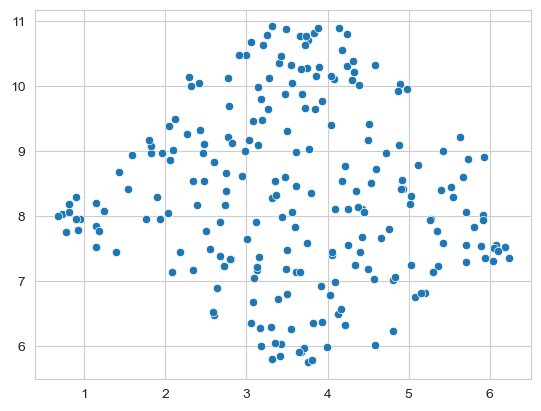

In [13]:
sns.scatterplot(x=anthems_umap[:, 0], y=anthems_umap[:, 1])
plt.show()

### No umap

In [14]:
def plot_internal(X, func, model_name, max_k=11, print=True, **kwargs):
    ks = range(2, max_k)
    results = pd.DataFrame(index=["Silhouette score", "Calinski-Harabasz index", "Davies-Bouldin index"], columns=ks)
    if type(X) is not np.ndarray:
        X = X.toarray()
        
    for k in tqdm(ks, desc=f"Testing {model_name}"):
        model = func(n_clusters=k, **kwargs)
        cluster_labels = model.fit_predict(X)
        results[k] = [silhouette_score(X, cluster_labels), 
                      calinski_harabasz_score(X, cluster_labels),
                      davies_bouldin_score(X, cluster_labels)]
    
    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].plot(ks, results.loc["Silhouette score"].to_list())
    ax[0].scatter(ks, results.loc["Silhouette score"].to_list())
    ax[0].set_xticks(ks)
    ax[0].set_xlabel("k")
    ax[0].set_ylabel("Silhouette score")
    ax[0].set_title("Silhouette score", size=14)
    ax[0].axvline(ks[np.argmax(results.loc["Silhouette score"].to_list())], color="r", linestyle="--", label="maximum", zorder=0)
    ax[0].legend()

    ax[1].plot(ks, results.loc["Calinski-Harabasz index"].to_list())
    ax[1].scatter(ks, results.loc["Calinski-Harabasz index"].to_list())
    ax[1].set_xticks(ks)
    ax[1].set_xlabel("k")
    ax[1].set_ylabel("Calinski-Harabasz index")
    ax[1].set_title("Calinski-Harabasz index", size=14)
    ax[1].axvline(ks[np.argmax(results.loc["Calinski-Harabasz index"].to_list())], color="r", linestyle="--", label="maximum", zorder=0)
    ax[1].legend()

    ax[2].plot(ks, results.loc["Davies-Bouldin index"].to_list())
    ax[2].scatter(ks, results.loc["Davies-Bouldin index"].to_list())
    ax[2].set_xticks(ks)
    ax[2].set_xlabel("k")
    ax[2].set_ylabel("Davies-Bouldin index")
    ax[2].set_title("Davies-Bouldin index", size=14)
    ax[2].axvline(ks[np.argmin(results.loc["Davies-Bouldin index"].to_list())], color="r", linestyle="--", label="minimum", zorder=0)
    ax[2].legend()

    plt.suptitle(f"Internal incides for {model_name} model", size=18)
    plt.tight_layout()
    plt.show()
    
    if print:
        return results

Testing AgglomerativeClustering:  33%|███▎      | 6/18 [00:00<00:00, 26.32it/s]

Testing AgglomerativeClustering: 100%|██████████| 18/18 [00:00<00:00, 24.70it/s]


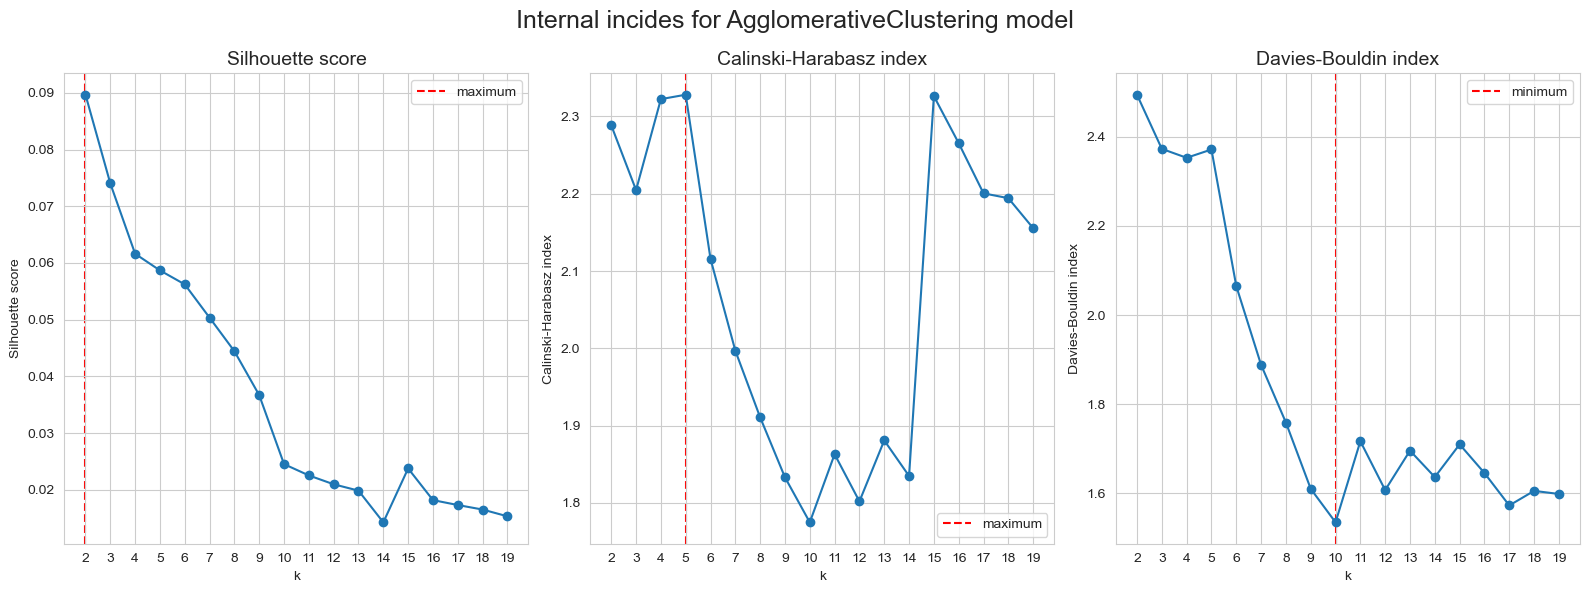

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Silhouette score,0.089663,0.074018,0.061622,0.058691,0.056229,0.050357,0.044443,0.036698,0.024542,0.022550,0.020990,0.019869,0.014281,0.023780,0.018200,0.017333,0.016536,0.015344
Calinski-Harabasz index,2.288572,2.204751,2.322460,2.328156,2.115707,1.996953,1.910736,1.833142,1.774914,1.863018,1.802017,1.880897,1.834859,2.326348,2.265457,2.200568,2.194316,2.155504
Davies-Bouldin index,2.494249,2.372801,2.352760,2.371390,2.065118,1.888310,1.758977,1.610306,1.535110,1.716966,1.607437,1.695915,1.636621,1.709993,1.645745,1.572986,1.605684,1.598741


In [15]:
plot_internal(anthems_embeddings, AgglomerativeClustering, "AgglomerativeClustering", max_k=20, metric="cosine", linkage="average")

In [16]:
clusterer = AgglomerativeClustering(n_clusters=5, metric='cosine', linkage='complete')
cluster_labels = clusterer.fit_predict(anthems_embeddings)

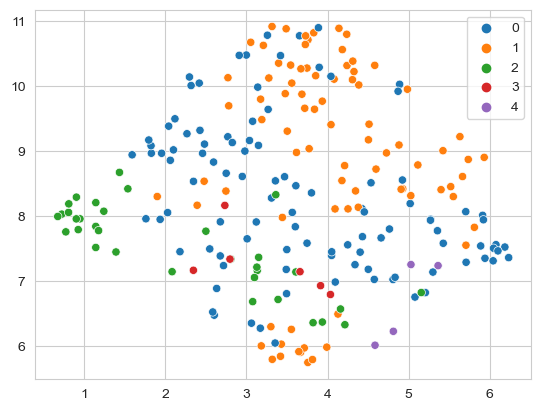

In [17]:
sns.scatterplot(x=anthems_umap[:, 0], y=anthems_umap[:, 1], hue=cluster_labels, palette="tab10")
plt.show()

### with umap

In [18]:
umap_embedding = umap.UMAP(n_components=70, metric='cosine').fit_transform(anthems_embeddings)

Testing AgglomerativeClustering: 100%|██████████| 18/18 [00:00<00:00, 59.37it/s]


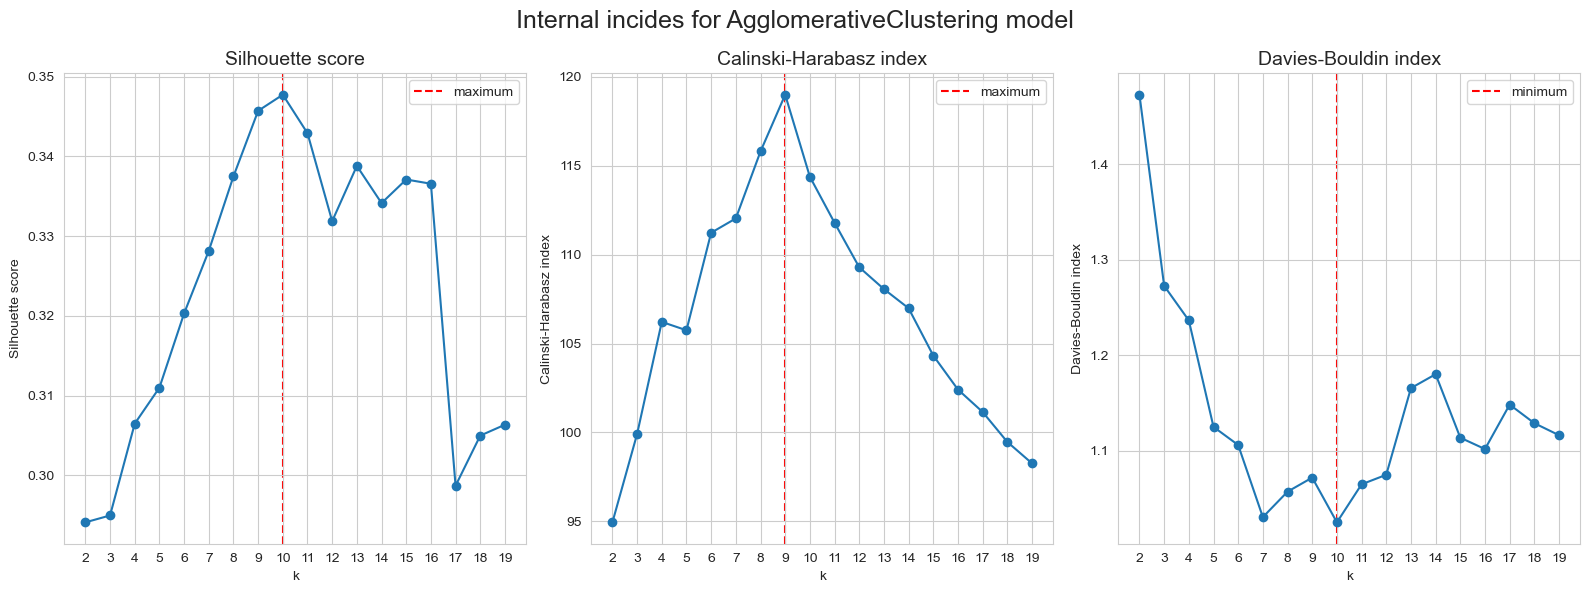

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Silhouette score,0.294100,0.294963,0.306481,0.310994,0.320309,0.328161,0.337504,0.345726,0.347747,0.342914,0.331878,0.338816,0.334149,0.337110,0.336578,0.298692,0.304981,0.306347
Calinski-Harabasz index,94.943624,99.910397,106.216962,105.746480,111.231527,112.036455,115.802658,118.994654,114.381702,111.794023,109.290896,108.063769,106.985797,104.325377,102.412606,101.151046,99.467301,98.262541
Davies-Bouldin index,1.473053,1.272873,1.236643,1.125105,1.106101,1.030572,1.057234,1.071965,1.025115,1.064945,1.074933,1.165714,1.180263,1.113781,1.101878,1.148435,1.128977,1.116388


In [19]:
plot_internal(umap_embedding, AgglomerativeClustering, "AgglomerativeClustering", max_k=20, metric="euclidean", linkage="ward")

Testing SpectralClustering: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]


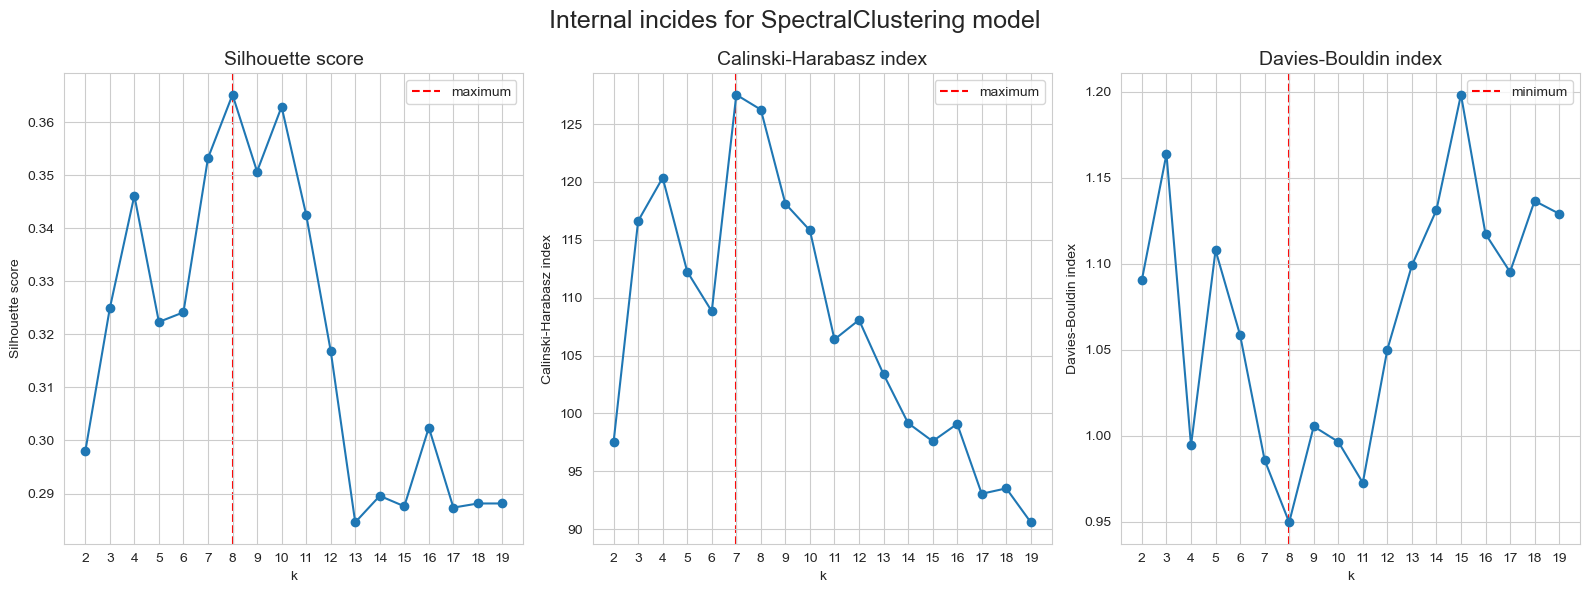

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Silhouette score,0.297928,0.324914,0.346171,0.322353,0.324163,0.353230,0.365189,0.350708,0.362921,0.342588,0.316913,0.284571,0.289566,0.287597,0.302448,0.287350,0.288126,0.288131
Calinski-Harabasz index,97.540495,116.632547,120.366679,112.257880,108.828109,127.542195,126.250533,118.122015,115.816579,106.394495,108.080808,103.382255,99.166961,97.597781,99.096290,93.058943,93.527504,90.590649
Davies-Bouldin index,1.090823,1.163838,0.994343,1.107872,1.058548,0.985864,0.949631,1.005430,0.996491,0.972637,1.050133,1.099056,1.131299,1.198353,1.117388,1.095258,1.136598,1.129132


In [20]:
plot_internal(umap_embedding, SpectralClustering, "SpectralClustering", max_k=20)

In [21]:
clusterer = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='ward')
cluster_labels = clusterer.fit_predict(umap_embedding)

In [22]:
ks = range(2, 19)

inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(umap_embedding)
    inertias.append(kmeans.inertia_)

elbow = KneeLocator(ks, inertias, curve='convex', direction='decreasing').elbow

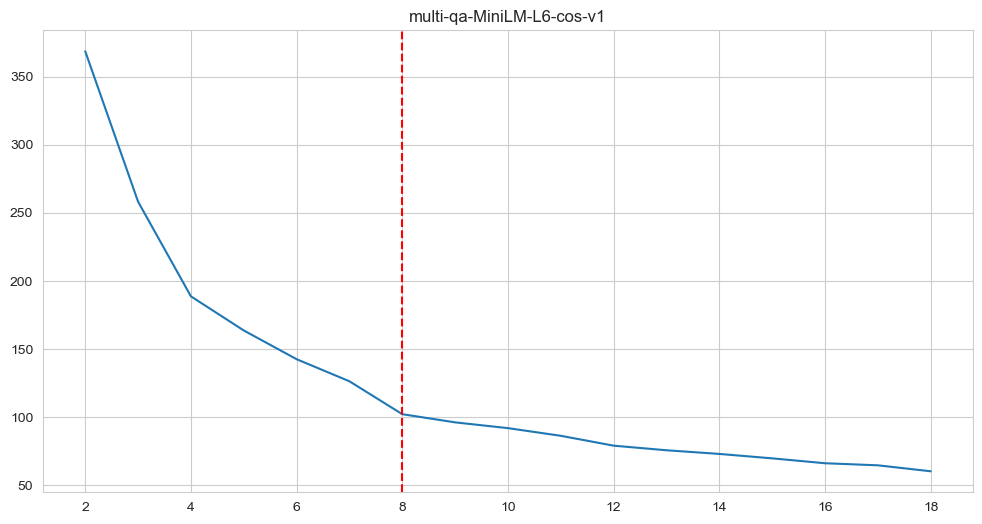

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))


sns.lineplot(x=ks, y=inertias, ax=ax)
ax.axvline(elbow, ls="--", color="red")
ax.set_title("multi-qa-MiniLM-L6-cos-v1")

plt.show()

In [24]:
kmeans = KMeans(n_clusters=elbow, n_init='auto')
kmeans.fit(umap_embedding)
k_means_cluster_labels = kmeans.predict(umap_embedding)

Testing Birch: 100%|██████████| 18/18 [00:01<00:00, 12.99it/s]


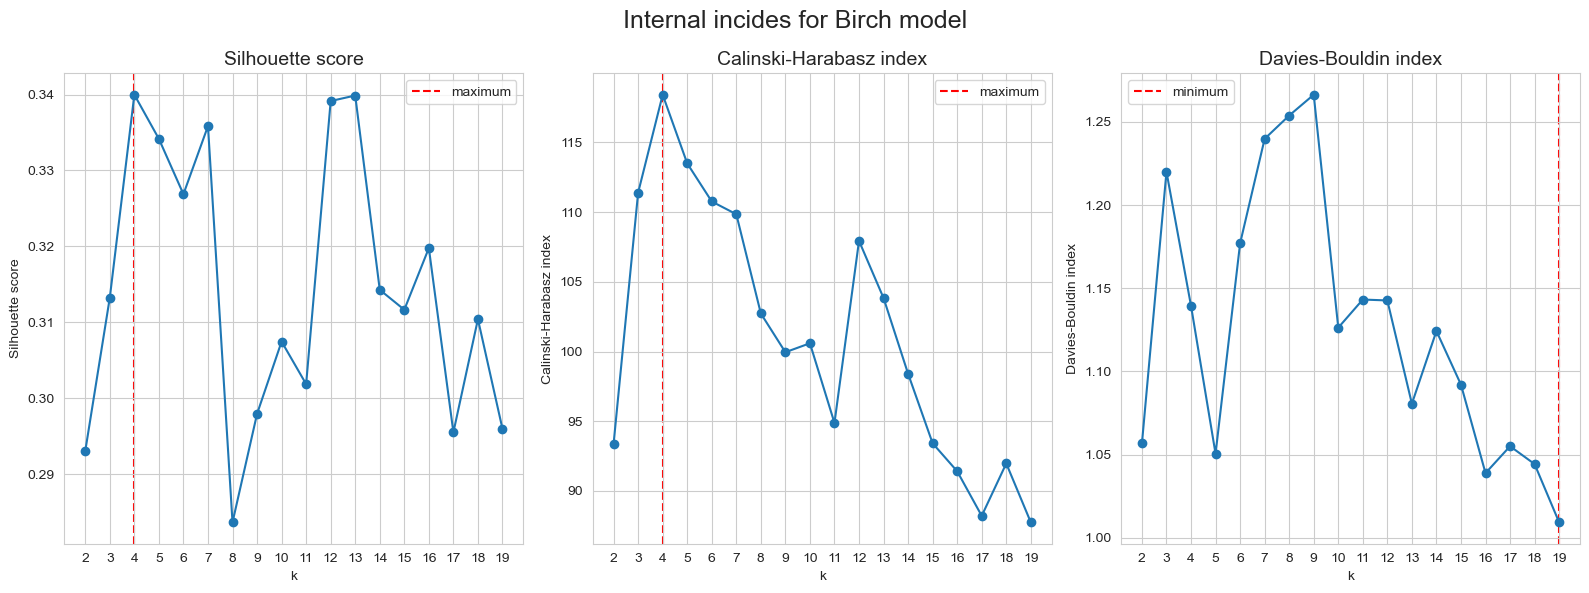

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Silhouette score,0.293037,0.313235,0.339983,0.334166,0.326876,0.335847,0.283634,0.297925,0.307454,0.301846,0.339150,0.339877,0.314275,0.311650,0.319772,0.295500,0.310405,0.295958
Calinski-Harabasz index,93.377205,111.401921,118.426656,113.497232,110.764444,109.851286,102.727618,99.948538,100.590821,94.872370,107.938724,103.837782,98.402110,93.412334,91.406662,88.205448,91.966742,87.741114
Davies-Bouldin index,1.056658,1.220009,1.139417,1.050501,1.176947,1.239798,1.253816,1.266324,1.126273,1.143190,1.142638,1.080566,1.124253,1.092029,1.038832,1.055003,1.044269,1.009249


In [25]:
plot_internal(umap_embedding, Birch, "Birch", max_k=20)

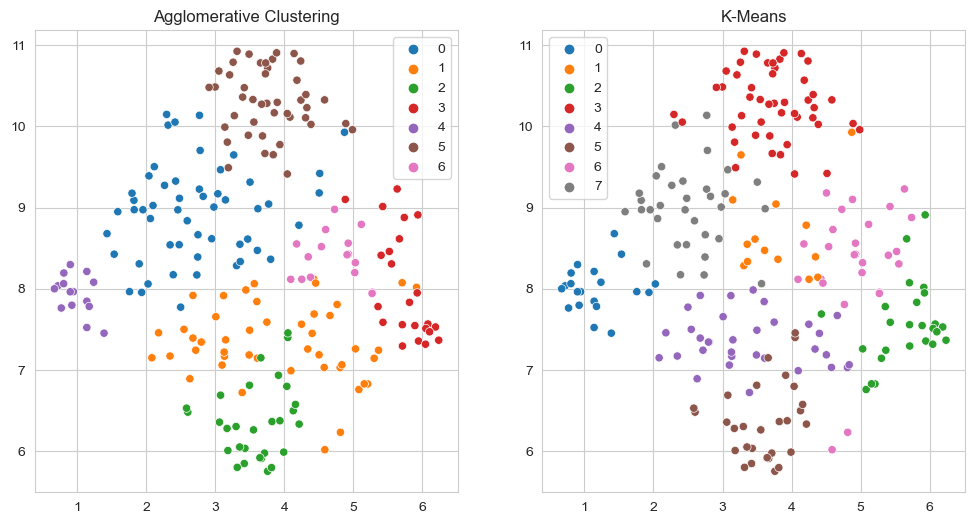

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(x=anthems_umap[:, 0], y=anthems_umap[:, 1], hue=cluster_labels.astype(int), palette="tab10", ax=ax[0])
ax[0].set_title("Agglomerative Clustering")

sns.scatterplot(x=anthems_umap[:, 0], y=anthems_umap[:, 1], hue=k_means_cluster_labels.astype(int), palette="tab10", ax=ax[1])
ax[1].set_title("K-Means")
plt.show()

In [27]:
plt.rcParams["font.family"] = "Rozha One"

In [28]:
indices = df[df.lyrics != ""].index

In [29]:
df["labels"] = max(cluster_labels) + 1
df.loc[indices, "labels"] = cluster_labels

In [30]:
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [31]:
set_matplotlib_formats('svg')

C:\Users\Manik\AppData\Local\Temp\ipykernel_15620\2718164820.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


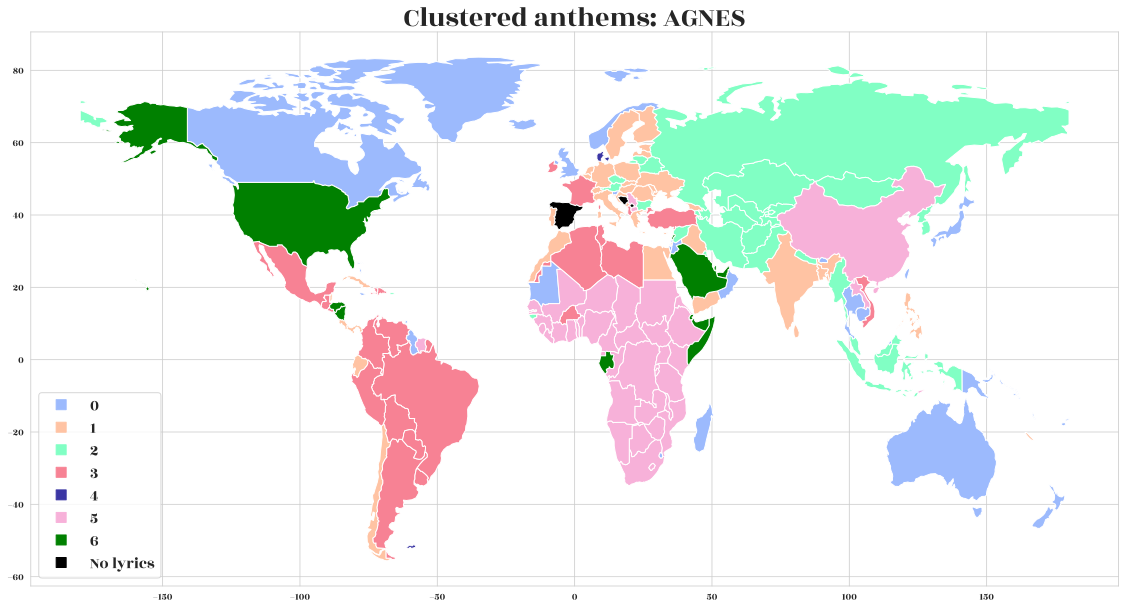

In [32]:
world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world_all.merge(df, on="iso_a3")
fig, ax = plt.subplots(figsize=(25, 10))

# "#9CBAFD"#81FFC4
colors = ["#9CBAFD", "#FFC3A3", "#81FFC4", "#F78294", "#3B36A4", "#F7B1D9", "green", "black"]

for i in range(clusterer.n_clusters + 1):
    countries = world[world["labels"] == i]
    countries.plot(ax=ax, color=colors[i], legend=True, label=world["labels"])

lines = [Line2D([0], [0], linestyle="none", marker="s", markersize=10, markerfacecolor=t.get_facecolor(), markeredgecolor=t.get_facecolor()) for t in ax.collections]
labels = [f"{i}" for i in range(clusterer.n_clusters)] + ["No lyrics"]
ax.legend(lines, labels, numpoints=1, loc="lower left", fontsize=16)
ax.set_title("Clustered anthems: AGNES", size=28)
plt.savefig("figures/hugginface_map.svg", transparent=True, bbox_inches="tight")
plt.show()

### Cluster analysis

In [378]:
clean_df["clusters"] = cluster_labels

C:\Users\Manik\AppData\Local\Temp\ipykernel_15488\4118393929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["clusters"] = cluster_labels


In [379]:
clean_df.sort_values(by="clusters", inplace=True)

C:\Users\Manik\AppData\Local\Temp\ipykernel_15488\3296699830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.sort_values(by="clusters", inplace=True)


In [380]:
clean_df

,iso_2,iso_a3,lyrics,clusters
Guinea-Bissau,GW,GNB,"Sun, sweat, verdure and sea, Centuries of pain...",0
Slovakia,SK,SVK,"Theres lightning over the Tatras, thunderclaps...",0
Mauritius,MU,MUS,"Glory to thee, Motherland, O motherland of min...",0
Cyprus,CY,CYP,I shall always recognise you By the dreadful s...,0
Finland,FI,FIN,"Our land, our land, our fatherland, Sound loud...",0
...,...,...,...,...
North Korea,KP,PRK,Let morning shine on the silver and gold of th...,6
Puerto Rico,PR,PRI,"The land of Borinquen, where I was born, is a ...",6
Russia,RU,RUS,"Russia our sacred stronghold, Russia our bel...",6
Tajikistan,TJ,TJK,"Our beloved country, We are happy to see your ...",6


In [381]:
client = OpenAI()

In [382]:
n_clusters = clusterer.n_clusters_

In [408]:
anthems_per_cluster = 12
output_to_a_file = ""

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    anthems_sample = "\n".join(
        clean_df[clean_df.clusters == i]
        .lyrics
        .sample(anthems_per_cluster, random_state=42)
        .values
    )

    output_to_a_file += f"Cluster {i}\n\n"

    messages = [
        {"role": "user", "content": f'What do the following national anthems have in common?\n\nNational anthems:\n"""\n{anthems_sample}\n"""\n\nTheme:'}
    ]

    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        temperature=0.0,
        max_tokens=50,
        top_p=1,
        frequency_penalty=0.,
        presence_penalty=0.)
    print(response.choices[0].message.content.replace("\n", ""))
    output_to_a_file += f"Theme: {response.choices[0].message.content.replace(chr(10), '')}\n\n"
    output_to_a_file += f"Anthems sample: {anthems_sample}\n\n"

    print("-" * 100)
    output_to_a_file += "-" * 100 + "\n"


with open("output.txt", "w") as f:
    f.write(output_to_a_file)

Cluster 0 Theme: All of these are national anthems of different countries.
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: All of these national anthems belong to countries that are part of the Commonwealth of Nations.
----------------------------------------------------------------------------------------------------
Cluster 2 Theme: All of these national anthems reference the country's flag.
----------------------------------------------------------------------------------------------------
Cluster 3 Theme: All of these national anthems emphasize the themes of freedom, national pride, resistance against oppression, and unity.
----------------------------------------------------------------------------------------------------
Cluster 4 Theme: All of these national anthems are from island nations or territories.
----------------------------------------------------------------------------------------------------
Clust

In [ ]:
clean_df.clusters.value_counts().min()

15